## SEIS 764-01: Assignment #6, By - Himanshu Gamit

Table of Content: Transfer Learning CNN
    1. Answer 1: Load and normalizing the Irish Images datasets using torchvision
    2. Answer 2: Create CNN Classifier
        - Define a Convolutional Neural Network using pretrained CNN
        - Define a loss function
    3. Answer 3: Neural Net Configuration - Used Pretrained weights of resnet18 - imagenet
        - Train the network on the training data
    4. Answer 4: Confusion Matrix and Accuracy
        - Valid the network on the Train/Valid data
    5. Answer 5:Precision, recall, F-score and a ROC curve for EACH class.
    
  Ref# 
1. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html 
1. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

In [1]:
# Libraries
import time
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from collections import namedtuple
from IPython.display import Image
import pandas as pd
import cv2

##sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import classification_report

# Any results you write to the current directory are saved as output.
#Pytorch Libraries
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler

%matplotlib inline
#Repeatability
seed = 2019
np.random.seed(seed)
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

## Step 1: Answer 1: Load and normalizing the Irish Images datasets using torchvision

* Load Data
* Sample Rows: 150 images, Data - Image and label (3 target labels(50 samples each))
* Input Size : 200 \* 200 \* 3
* Torch Dataset- Loading and normalizing

In [2]:
# Data augmentation and normalization(resnet18) for training
# Just normalization(resnet18) for validation

trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                           ])

train_set = datasets.ImageFolder("C:/tmp/iris-as-images/Iris_Imgs", transform = trans)
#total number of samples
data_list = []
for i, (idx, label) in enumerate(train_set.__dict__['samples']):
    data_list.append([idx, label]) 
df = pd.DataFrame(data_list, columns = ['ImageID', 'label'])
df.shape

(150, 2)

In [3]:
train_set.__dict__['class_to_idx']

{'setosa': 0, 'versicolor': 1, 'virginica': 2}

In [4]:
#total number of samples
len(train_set.__dict__['samples'])

150

In [5]:
#Input size
img = cv2.imread('/kaggle/input/iris-as-images/Iris_Imgs/virginica/Img_143.jpg')
height, width, channels = img.shape
print (height, width, channels)

200 200 3


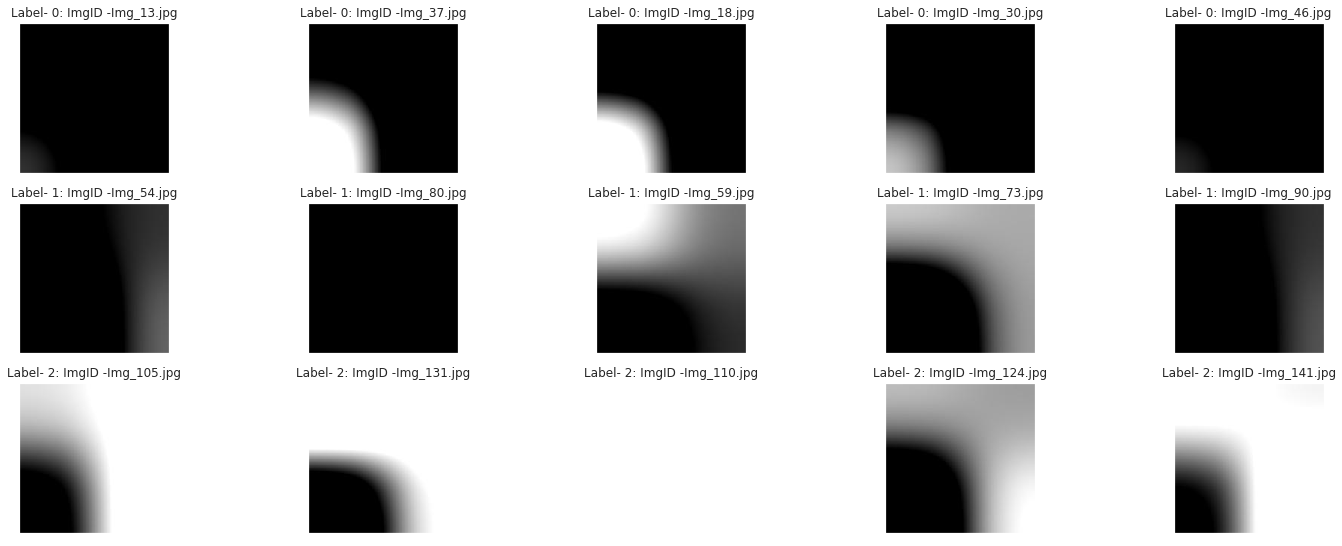

In [6]:
# display 5 images from each class
fig = plt.figure(figsize=(25, 16))
for class_id in sorted(df.label.unique()):
    for i, (idx, row) in enumerate(df.loc[df['label'] == class_id].sample(5, random_state=seed).iterrows()):
        ax = fig.add_subplot(5, 5, class_id * 5 + i + 1, xticks=[], yticks=[])
        path=f"{row['ImageID']}"
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        ax.set_title('Label- %d: ImgID -%s' % (class_id, row['ImageID'].rsplit('/', 1)[1]) )

In [7]:
df.head()

,ImageID,label
0,/kaggle/input/iris-as-images/Iris_Imgs/setosa/...,0
1,/kaggle/input/iris-as-images/Iris_Imgs/setosa/...,0
2,/kaggle/input/iris-as-images/Iris_Imgs/setosa/...,0
3,/kaggle/input/iris-as-images/Iris_Imgs/setosa/...,0
4,/kaggle/input/iris-as-images/Iris_Imgs/setosa/...,0


#### Splitting and Loading Dataset

In [8]:
##strtified data split
X_train, X_test, y_train, y_test = train_test_split(df['ImageID'], df['label'],
                                                    stratify=df['label'], 
                                                    test_size=0.4)

In [9]:
##Data loader for Network input
batch_size = 24

# Add dataset to dataloader that handles batching
train_loader = DataLoader(train_set, batch_size=batch_size,
                                sampler=torch.utils.data.sampler.SubsetRandomSampler(np.array(X_train.index)))
val_loader = DataLoader(train_set,batch_size=batch_size, 
                                           sampler=torch.utils.data.sampler.SubsetRandomSampler(np.array(X_test.index)))

class_names = ('setosa', 'versicolor', 'virginica')

#### Training the model - Supporting Functions

1.     Training
2.     Validation

Note: Printing has been commented out.

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler):
    model.train()
    model.to(device)

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.to(device)
        target = target.to(device) # all data & model on same device

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    scheduler.step()
    end_time = time.time()
    
    running_loss /= len(train_loader)
    #print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

def test_model(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.to(device)
            target = target.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        #print('Testing Loss: ', running_loss)
        #print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

## Answer 2: Create CNN Classifier - Transfer Learning
        - Define a Convolutional Neural Network
        - Used Pretrained weights of resnet18 - imagenet
        - Define a loss function

**These two major transfer learning scenarios look as follows:**
    
*     **Type 1: Finetuning the convnet:**  It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network.
*     **Type 2: ConvNet as fixed feature extractor:** Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

**Let's do Type 1: Finetuning the convnet:**
Load a pretrained model and reset final fully connected layer. Added final classification layer.

In [11]:
model_finetune = models.resnet18(pretrained=True)
num_features = model_finetune.fc.in_features
# Here the size of each output sample is set to 3 output classes.
model_finetune.fc = nn.Linear(num_features, 3)
model_finetune = model_finetune.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_finetune.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.7MB/s]


## Answer 3: Neural Net Configuration
        - Train the network on the training data

In [12]:
print(model_finetune)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [13]:
n_epochs = 25
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    #print("============Epoch====== :", i)
    train_loss = train_epoch(model_finetune, train_loader, criterion, optimizer, exp_lr_scheduler)
    test_loss, test_acc = test_model(model_finetune, val_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    #print('='*20)

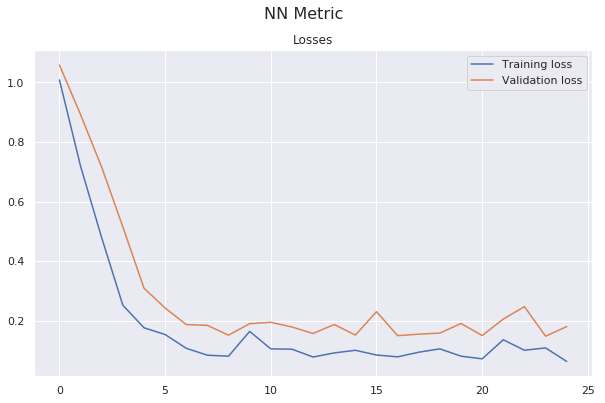

In [14]:
plt.figure(figsize=(10,6))

s_title ='NN Metric'
plt.suptitle(s_title, fontsize=16)

#plt.subplot(2,2,1)
plt.gca().set_title('Losses')
# plotting the training and validation loss
plt.plot(Train_loss, label='Training loss')
plt.plot(Test_loss, label='Validation loss')
plt.legend()
plt.show()

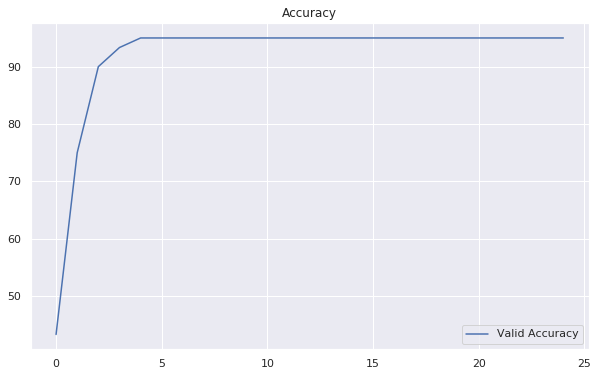

In [15]:
plt.figure(figsize=(10,6))
#plt.subplot(2,2,2)
plt.gca().set_title('Accuracy')
plt.plot(Test_acc, label='Valid Accuracy')
plt.legend()
plt.show()

In [16]:
PATH = './irish_net_finetuned.pth'
torch.save(model_finetune.state_dict(), PATH)

In [17]:
model_finetune = models.resnet18(pretrained=True)
num_features = model_finetune.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_finetune.fc = nn.Linear(num_features, 3)
model_finetune = model_finetune.to(device)
model_finetune.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
correct = 0
total = 0
preds_valid = []
lab_valid = []
probs_valid = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model_finetune(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        preds_valid.extend(predicted.detach().cpu().numpy())
        probs_valid.extend(torch.nn.functional.softmax(outputs, dim=1).detach().cpu().numpy())
        lab_valid.extend(labels.detach().cpu().numpy())
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the val images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the val images: 93 %


In [19]:
correct = 0
total = 0
preds_train = []
lab_train = []
probs_train = []
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = model_finetune(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        preds_train.extend(predicted.detach().cpu().numpy())
        probs_train.extend(torch.nn.functional.softmax(outputs, dim=1).detach().cpu().numpy())
        lab_train.extend(labels.detach().cpu().numpy())
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

print(preds_valid)
print(lab_valid)
print(preds_train)
print(lab_train)

Accuracy of the network on the train images: 97 %
[0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1, 2, 0, 2, 0, 2, 2, 1, 1, 0, 0, 0, 2, 2, 0, 0, 1, 0, 1, 2, 0, 1, 1, 0, 1, 1, 0, 2, 1, 1, 0, 2, 2, 2, 0, 0, 2, 1, 2, 1, 1, 2, 0, 1, 2, 0, 2, 2, 2]
[0, 2, 0, 0, 2, 2, 2, 0, 0, 0, 1, 1, 2, 0, 2, 0, 2, 2, 1, 1, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 1, 0, 2, 1, 1, 1, 2, 2, 2, 0, 0, 1, 1, 2, 1, 1, 2, 0, 1, 2, 0, 2, 2, 2]
[1, 0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 1, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 1, 2, 1, 0, 2, 1, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 1, 0, 2, 2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 2, 0, 1, 1, 0, 2, 1, 1]
[1, 0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 2, 0, 2, 1, 1, 2, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 0, 2, 2, 0, 0, 2, 1, 0, 2, 2, 0, 0, 1, 2, 1, 0, 2, 1, 1, 0, 2, 0, 2, 0, 1, 0, 2, 0, 1, 1, 0, 2, 2, 0, 2, 2, 1, 0, 2, 1, 2, 2, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 2, 0, 1, 1, 0, 2, 0, 1]


In [20]:
probs = torch.nn.functional.softmax(outputs, dim=1)

In [21]:
torch.sum(probs, dim=1) # size = [1, ncol]

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')

In [22]:
torch.max(outputs.data, 1)

torch.return_types.max(
values=tensor([1.6061, 2.5779, 1.1213, 3.2356, 1.1908, 2.8210, 2.8927, 0.9471, 2.7486,
        3.9223, 2.6488, 3.3621, 2.1783, 2.6412, 3.1744, 3.9245, 1.1213, 3.3442],
       device='cuda:0'),
indices=tensor([1, 0, 1, 0, 1, 1, 0, 1, 1, 2, 2, 0, 1, 1, 0, 2, 1, 1], device='cuda:0'))

## Answer 4: Confusion Matrix and Accuracy
        - Valid the network on the Train/Valid data
### {'setosa': 0, 'versicolor': 1, 'virginica': 2}

**Accuracy classification score:**
In multilabel classification, this function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.

Train Accuracy 0.9777777777777777
Valid Accuracy 0.9333333333333333


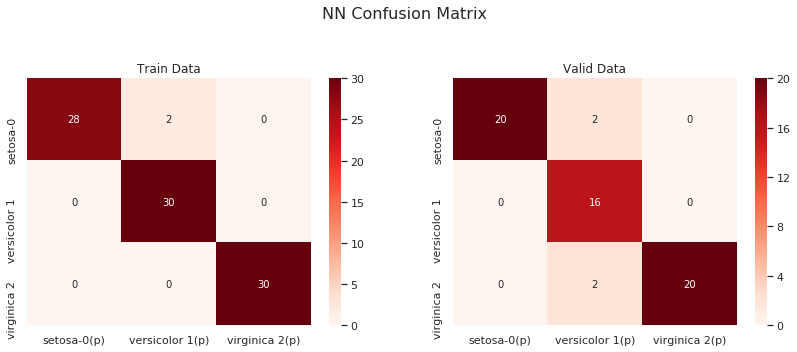

In [23]:
#%debug
print("Train Accuracy", accuracy_score(lab_train, preds_train))
print("Valid Accuracy", accuracy_score(lab_valid, preds_valid))

df_cmtr = pd.DataFrame(confusion_matrix(lab_train, preds_train), index = ['setosa-0', 'versicolor 1', 'virginica 2'],
                  columns = ['setosa-0(p)', 'versicolor 1(p)', 'virginica 2(p)'])

plt.figure(figsize=(14,10))

s_title ='NN Confusion Matrix'
plt.suptitle(s_title, fontsize=16)

plt.subplot(2,2,1)
plt.gca().set_title('Train Data')
sns.heatmap(df_cmtr, annot=True, cmap=plt.cm.Reds)


df_cm = pd.DataFrame(confusion_matrix(preds_valid, lab_valid), index = ['setosa-0', 'versicolor 1', 'virginica 2'],
                  columns = ['setosa-0(p)', 'versicolor 1(p)', 'virginica 2(p)'])


plt.subplot(2,2,2)
plt.gca().set_title('Valid Data')
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Reds)
plt.show()

### Answer 5: Precision, recall, F-score and a ROC curve for EACH class.

In [24]:
#Printing Classification Report - Train Data
print(classification_report(lab_train, preds_train))

              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30
           2       1.00      1.00      1.00        30

    accuracy                           0.98        90
   macro avg       0.98      0.98      0.98        90
weighted avg       0.98      0.98      0.98        90



In [25]:
#Printing Classification Report - Test Data
print(classification_report(lab_valid, preds_valid))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        20
           1       1.00      0.80      0.89        20
           2       0.91      1.00      0.95        20

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



In [26]:
def create_roc_df(lab_valid, probs_valid):
    y_valid = pd.DataFrame(lab_valid, columns=["lab_valid"])
    y_valid = pd.get_dummies(y_valid["lab_valid"])
    y_probs_valid = pd.DataFrame(probs_valid, columns=["probs_0", "probs_1", "probs_2"])
    
    #getting ROC curve values
    fpr0 , tpr0 , thresholds0 = roc_curve ( y_valid[0], y_probs_valid["probs_0"])
    fpr1 , tpr1 , thresholds1 = roc_curve ( y_valid[1], y_probs_valid["probs_1"])
    fpr2 , tpr2 , thresholds2 = roc_curve ( y_valid[2], y_probs_valid["probs_2"])

    df_roc2 = pd.DataFrame()

    df_roc2["fpr"] = fpr2
    df_roc2["tpr"] = tpr2
    df_roc2['data'] = 'class2'

    df_roc1 = pd.DataFrame()

    df_roc1["fpr"] = fpr1
    df_roc1["tpr"] = tpr1
    df_roc1['data'] = 'class1'

    df_roc = pd.DataFrame()
    df_roc["fpr"] = fpr0
    df_roc["tpr"] = tpr0
    df_roc['data'] = 'class0'

    df_roc = df_roc.append(df_roc1, ignore_index=True)
    df_roc = df_roc.append(df_roc2, ignore_index=True)
    return df_roc

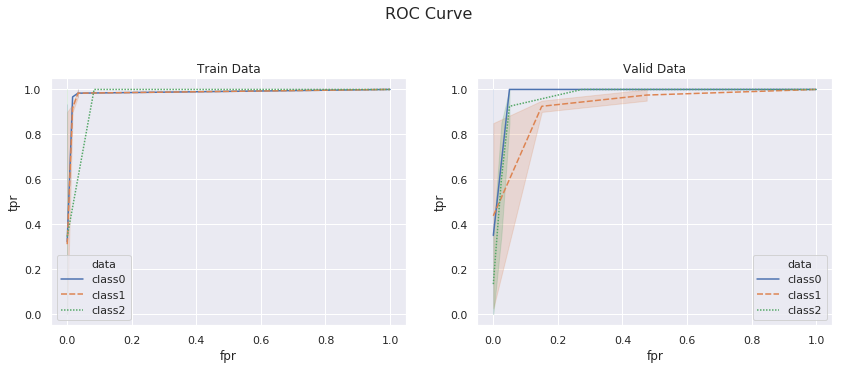

In [27]:
df_roc_train = create_roc_df(lab_train, probs_train)

plt.figure(figsize=(14,10))

s_title ='ROC Curve'
plt.suptitle(s_title, fontsize=16)

plt.subplot(2,2,1)
plt.gca().set_title('Train Data')
sns.lineplot(x="fpr", y="tpr",
                  hue="data", style="data", data=df_roc_train)

df_roc_valid = create_roc_df(lab_valid, probs_valid)

plt.subplot(2,2,2)
plt.gca().set_title('Valid Data')
sns.lineplot(x="fpr", y="tpr",
                  hue="data", style="data", data=df_roc_valid)
plt.show()

## Additional

#### Type 2: ConvNet as fixed feature extractor
Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [28]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 3)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [29]:
n_epochs = 20
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    #print("============Epoch====== :", i)
    train_loss = train_epoch(model_conv, train_loader, criterion, optimizer_conv, exp_lr_scheduler)
    test_loss, test_acc = test_model(model_conv, val_loader, criterion)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    #print('='*20)

In [30]:
correct = 0
total = 0
preds_valid = []
lab_valid = []
probs_valid = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model_conv(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        preds_valid.extend(predicted.detach().cpu().numpy())
        probs_valid.extend(torch.nn.functional.softmax(outputs, dim=1).detach().cpu().numpy())
        lab_valid.extend(labels.detach().cpu().numpy())
        correct += (predicted == labels.to(device)).sum().item()

print('Accuracy of the network on the val images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the val images: 88 %
